In [1]:
"""
Baseline for machine learning project on road segmentation.
This simple baseline consits of a CNN with two convolutional+pooling layers with a soft-max loss

Credits: Aurelien Lucchi, ETH Zürich
"""


# import libraries
import gzip
import os
import sys
import urllib
import matplotlib.image as mpimg
from PIL import Image

# to plot images in the notebook
from matplotlib import pyplot as plt

import code

import tensorflow.python.platform

import numpy
import tensorflow as tf

import time
from datetime import timedelta
import math

from helper_functions import *

Parameters

In [2]:
TRAINING_SIZE = 20
VALIDATION_SIZE = 5  # Size of the validation set.
SEED = 50  # Set to None for random seed.
BATCH_SIZE = 16 # 64
NUM_EPOCHS = 8 # how many as you like
RESTORE_MODEL = False # If True, restore existing model instead of training a new one
RECORDING_STEP = 50
TEST = False  # if we want to predict test image as well
TESTING_SIZE = 50 # number of test images i.e. 50
print('NUM_CHANNELS: ',NUM_CHANNELS )
print('PIXEL_DEPTH: ',PIXEL_DEPTH)
print ('NUM_LABELS: ',NUM_LABELS)
print ('IMG_PATCH_SIZE: ',IMG_PATCH_SIZE)


NUM_CHANNELS:  3
PIXEL_DEPTH:  255
NUM_LABELS:  2
IMG_PATCH_SIZE:  16


Where to save stuff

In [3]:
tf.app.flags.DEFINE_string('train_dir', '/tmp/mnist/test1',
                           """Directory where to write event logs """
                           """and checkpoint.""")
FLAGS = tf.app.flags.FLAGS

Directories:

In [4]:
data_dir = 'training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/'

Additional parameters:

In [5]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

some additional functions:

In [6]:
# Make an image summary for 4d tensor image with index idx
def get_image_summary(img, idx = 0):
    V = tf.slice(img, (0, 0, 0, idx), (1, -1, -1, 1))
    img_w = img.get_shape().as_list()[1]
    img_h = img.get_shape().as_list()[2]
    min_value = tf.reduce_min(V)
    V = V - min_value
    max_value = tf.reduce_max(V)
    V = V / (max_value*PIXEL_DEPTH)
    V = tf.reshape(V, (img_w, img_h, 1))
    V = tf.transpose(V, (2, 0, 1))
    V = tf.reshape(V, (-1, img_w, img_h, 1))
    return V

# Make an image summary for 3d tensor image with index idx
def get_image_summary_3d(img):
    V = tf.slice(img, (0, 0, 0), (1, -1, -1))
    img_w = img.get_shape().as_list()[1]
    img_h = img.get_shape().as_list()[2]
    V = tf.reshape(V, (img_w, img_h, 1))
    V = tf.transpose(V, (2, 0, 1))
    V = tf.reshape(V, (-1, img_w, img_h, 1))
    return V

# Get a concatenation of the prediction and groundtruth for given input file
def get_prediction_with_groundtruth(filename, image_idx):
    imageid = "satImage_%.3d" % image_idx
    image_filename = filename + imageid + ".png"
    img = mpimg.imread(image_filename)

    img_prediction = get_prediction(img)
    cimg = concatenate_images(img, img_prediction)

    return cimg

Extract the data into numpy arrays:

In [7]:
# Extract it into numpy arrays.
train_data = extract_data(train_data_filename, TRAINING_SIZE)
train_labels = extract_labels(train_labels_filename, TRAINING_SIZE)

Loading training/images/satImage_001.png
Loading training/images/satImage_002.png
Loading training/images/satImage_003.png
Loading training/images/satImage_004.png
Loading training/images/satImage_005.png
Loading training/images/satImage_006.png
Loading training/images/satImage_007.png
Loading training/images/satImage_008.png
Loading training/images/satImage_009.png
Loading training/images/satImage_010.png
Loading training/images/satImage_011.png
Loading training/images/satImage_012.png
Loading training/images/satImage_013.png
Loading training/images/satImage_014.png
Loading training/images/satImage_015.png
Loading training/images/satImage_016.png
Loading training/images/satImage_017.png
Loading training/images/satImage_018.png
Loading training/images/satImage_019.png
Loading training/images/satImage_020.png
Loading training/groundtruth/satImage_001.png
Loading training/groundtruth/satImage_002.png
Loading training/groundtruth/satImage_003.png
Loading training/groundtruth/satImage_004.

Balance the data:

In [8]:
num_epochs = NUM_EPOCHS
# Now check the size of both classes and balance ###############################
c0 = 0
c1 = 0
for i in range(len(train_labels)):
    if train_labels[i][0] == 1:
        c0 = c0 + 1
    else:
        c1 = c1 + 1
print ('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))
# balance to take the same number of patches with c0 and c1 classes
print ('Balancing training data...')
min_c = min(c0, c1)
idx0 = [i for i, j in enumerate(train_labels) if j[0] == 1]
idx1 = [i for i, j in enumerate(train_labels) if j[1] == 1]
new_indices = idx0[0:min_c] + idx1[0:min_c]
print ('len(new_indices): ',len(new_indices))
print ('train_data.shape: ',train_data.shape)
train_data = train_data[new_indices,:,:,:]
train_labels = train_labels[new_indices]
print ('new train_data.shape: ',train_data.shape)
train_size = train_labels.shape[0]

c0 = 0
c1 = 0
for i in range(len(train_labels)):
    if train_labels[i][0] == 1:
        c0 = c0 + 1
    else:
        c1 = c1 + 1
print ('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))
# END of balancing #############################################################

Number of data points per class: c0 = 9450 c1 = 3050
Balancing training data...
len(new_indices):  6100
train_data.shape:  (12500, 16, 16, 3)
new train_data.shape:  (6100, 16, 16, 3)
Number of data points per class: c0 = 3050 c1 = 3050


In [9]:
def plot_patch(array):
    plt.imshow(array, interpolation='nearest')
    plt.show()
    
def plot_4_patch(images):
    if len(images) != 4:
        print ("Error, not 4 images")
    fig, axes = plt.subplots(2, 2)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='binary')
        xlabel = "image {0}".format(i)
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

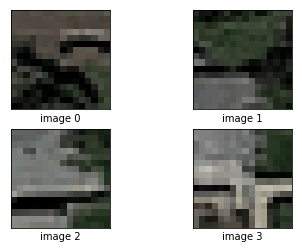

(16, 16, 3)

In [10]:
data = train_data[0,:,:,:] # a lot of these

#plot_patch(array=data)
data = train_data[0:4,:,:,:]
plot_4_patch(data)
train_data[0,:,:,:].shape

## Variables

In [11]:
# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step using the {feed_dict} argument to the Run() call below.
with tf.name_scope('input'):
    train_data_node = tf.placeholder(
        tf.float32,
        shape=(BATCH_SIZE, IMG_PATCH_SIZE, IMG_PATCH_SIZE, NUM_CHANNELS))
    train_labels_node = tf.placeholder(tf.float32,
                                       shape=(BATCH_SIZE, NUM_LABELS))
    
    train_all_data_node = tf.constant(train_data)

# Weights and biases

In [12]:
# The variables below hold all the trainable weights. They are passed an
# initial value which will be assigned when when we call:
# {tf.initialize_all_variables().run()}
def new_weights(shape,stddev_ = 0.05):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev_,seed=SEED),name="W")

def new_biases(length):
    return tf.Variable(tf.constant(0.1, shape=[length]),name="B")

with tf.name_scope("conv1"):
    conv1_weights = new_weights([5, 5, NUM_CHANNELS, 32]) # 5x5 filter, depth 32.
    conv1_biases = tf.Variable(tf.zeros([32]), name = "B")

with tf.name_scope("conv2"):
    conv2_weights = new_weights([5, 5, 32, 64])
    conv2_biases = new_biases(length=64)

with tf.name_scope("fc1"):
    fc1_weights = new_weights(shape= [int(IMG_PATCH_SIZE / 4 * IMG_PATCH_SIZE / 4 * 64), 512],
                                stddev_ = 0.1) # fully connected, depth 512.
    fc1_biases = new_biases(length=512)

with tf.name_scope("fc2"):
    fc2_weights = new_weights(shape= [512, NUM_LABELS],stddev_ = 0.1)
    fc2_biases = new_biases(length=NUM_LABELS)

In [13]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True,name="conv"):  # Use 2x2 max-pooling.
    with tf.name_scope(name):
        # Shape of the filter-weights for the convolution.
        # This format is determined by the TensorFlow API.
        shape = [filter_size, filter_size, num_input_channels, num_filters]

        # Create new weights aka. filters with the given shape.
        weights = new_weights(shape=shape)

        # Create new biases, one for each filter.
        biases = new_biases(length=num_filters)

        # Create the TensorFlow operation for convolution.
        # Note the strides are set to 1 in all dimensions.
        # The first and last stride must always be 1,
        # because the first is for the image-number and
        # the last is for the input-channel.
        # But e.g. strides=[1, 2, 2, 1] would mean that the filter
        # is moved 2 pixels across the x- and y-axis of the image.
        # The padding is set to 'SAME' which means the input image
        # is padded with zeroes so the size of the output is the same.
        layer = tf.nn.conv2d(input=input,
                             filter=weights,
                             strides=[1, 1, 1, 1],
                             padding='SAME')

        # Add the biases to the results of the convolution.
        # A bias-value is added to each filter-channel.
        layer += biases

        # Use pooling to down-sample the image resolution?
        if use_pooling:
            # This is 2x2 max-pooling, which means that we
            # consider 2x2 windows and select the largest value
            # in each window. Then we move 2 pixels to the next window.
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 2, 2, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME')

        # Rectified Linear Unit (ReLU).
        # It calculates max(x, 0) for each input pixel x.
        # This adds some non-linearity to the formula and allows us
        # to learn more complicated functions.
        layer = tf.nn.relu(layer)

        # Note that ReLU is normally executed before the pooling,
        # but since relu(max_pool(x)) == max_pool(relu(x)) we can
        # save 75% of the relu-operations by max-pooling first.

        # We return both the resulting layer and the filter-weights
        # because we will plot the weights later.
    return layer, weights

In [14]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [15]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True,name="fc"): # Use Rectified Linear Unit (ReLU)?
    with tf.name_scope(name):
        # Create new weights and biases.
        weights = new_weights(shape=[num_inputs, num_outputs])
        biases = new_biases(length=num_outputs)

        # Calculate the layer as the matrix multiplication of
        # the input and weights, and then add the bias-values.
        layer = tf.matmul(input, weights) + biases
        
        # Use ReLU?
        if use_relu:
            layer = tf.nn.relu(layer)

    return layer

# LAYER CREATION

#### We create convolutional layers:

In [16]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=train_data_node,
                   num_input_channels=NUM_CHANNELS,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv1

<tf.Tensor 'conv/Relu:0' shape=(16, 8, 8, 16) dtype=float32>

In [17]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
layer_conv2

<tf.Tensor 'conv_1/Relu:0' shape=(16, 4, 4, 36) dtype=float32>

#### Flatten:

In [18]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape:0' shape=(16, 576) dtype=float32>

In [19]:
num_features

576

#### fully connected layers:

In [20]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'fc/Relu:0' shape=(16, 128) dtype=float32>

In [21]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=NUM_LABELS,
                         use_relu=False)
layer_fc2

<tf.Tensor 'fc_1/add:0' shape=(16, 2) dtype=float32>

# rewrite layer creation in a model:

In [22]:
def model (data = train_data_node,train=False):
    # conv 1
    layer_conv1, weights_conv1 = \
    new_conv_layer(input=data,
                   num_input_channels=NUM_CHANNELS,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
    # conv 2
    layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    # flatten
    layer_flat, num_features = flatten_layer(layer_conv2)
    
    # fully connected 1
    layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
    # dropout?
    if train:
        layer_fc1 = tf.nn.dropout(layer_fc1, 0.5, seed=SEED)
    
    # fully connected 2
    layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=NUM_LABELS,
                         use_relu=False)
    
    
    out = layer_fc2
    return out
    

#### cost function to be optimized:

In [23]:
# logits = layer_fc2 
logits = model(data = train_data_node, train=True)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=train_labels_node)

with tf.name_scope("xent"): 
    loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar('loss', loss)
    
    # to use the rest, the weights should be defined outside the model
    
    #regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
    #                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
    # Add the regularization term to the loss.
    #loss += 5e-4 * regularizers

### optimizer:

In [24]:
adam = False
batch = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
        0.01,                # Base learning rate.
        batch * BATCH_SIZE,  # Current index into the dataset.
        train_size,          # Decay step.
        0.95,                # Decay rate.
        staircase=True,name="learning_rate")
# write it down to tensorboard
tf.summary.scalar('learning_rate', learning_rate)

if adam:
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss,global_step=batch)
else:
    optimizer = tf.train.MomentumOptimizer(learning_rate,
                                           0.0).minimize(loss,
                                                         global_step=batch)

#### Predicted Class:

In [25]:
y_pred = tf.nn.softmax(logits)

y_pred_class = tf.argmax(y_pred, axis=1) # not usefull I think

In [26]:
# We'll compute them only once in a while by calling their {eval()} method.
train_all_prediction = tf.nn.softmax(model(train_all_data_node))

#### save 

In [27]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

#### measure of performances:

In [28]:
correct_prediction = tf.equal(y_pred, train_labels_node)
# or arg max of each??

In [29]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### helpers for the optimisation:

We do it on a small batch so that it is faster

In [30]:
train_batch_size = BATCH_SIZE
BATCH_SIZE

16

In [36]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations = 0):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    # Build the summary operation based on the TF collection of Summaries.
    

    print ('Initialized!')
    # Loop through training steps.
    print ('Total number of iterations = ' + str(int(num_epochs * train_size / BATCH_SIZE)))

    training_indices = range(train_size)
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    
    for iepoch in range(num_epochs):

        # Permute training indices
        perm_indices = numpy.random.permutation(training_indices)

        for step in range (int(train_size / BATCH_SIZE)):

            offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
            batch_indices = perm_indices[offset:(offset + BATCH_SIZE)]

            # Compute the offset of the current minibatch in the data.
            # Note that we could use better randomization across epochs.
            batch_data = train_data[batch_indices, :, :, :]
            batch_labels = train_labels[batch_indices]
            # This dictionary maps the batch data (as a numpy array) to the
            # node in the graph is should be fed to.
            feed_dict = {train_data_node: batch_data,
                         train_labels_node: batch_labels}

            if step % RECORDING_STEP == 0:

                summary_str, _, l, lr, predictions = s.run(
                    [summary_op, optimizer, loss, learning_rate, y_pred],
                    feed_dict=feed_dict)

                summary_str = s.run(summary_op, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
                summary_writer.flush()

                print ('global step:', iepoch*int(train_size / BATCH_SIZE)+step,\
                        ' over ',num_epochs*int(train_size / BATCH_SIZE))
                print ('Epoch: ', iepoch, '   || Step',float(step))
                print ('Minibatch loss: %.3f, learning rate: %.6f' % (l, lr))
                print ('Minibatch error: %.1f%%' % error_rate(predictions,
                                                             batch_labels))

                sys.stdout.flush()
            else:
                # Run the graph and fetch some of the nodes.
                _, l, lr, predictions = s.run(
                    [optimizer, loss, learning_rate, y_pred],
                    feed_dict=feed_dict)

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

# Tensorflow RUN

In [32]:
s = tf.Session()

## initialise variables and optimise

In [37]:
with tf.Session() as s:
    
    if RESTORE_MODEL:
        # Restore variables from disk.
        saver.restore(s, FLAGS.train_dir + "/model.ckpt")
        print("Model restored.")

    else:
        s.run(tf.global_variables_initializer())

        summary_op = tf.summary.merge_all()
        summary_writer = tf.summary.FileWriter(FLAGS.train_dir)
        summary_writer.add_graph(s.graph)

        # optimize
        optimize(num_iterations=1)

        # Save the variables to disk.
        save_path = saver.save(s, FLAGS.train_dir + "/model.ckpt")
        print("Model saved in file: %s" % save_path)

    print ("Running prediction on training set")
    prediction_training_dir = "predictions_training/"
    if not os.path.isdir(prediction_training_dir):
        os.mkdir(prediction_training_dir)
    for i in range(1, TRAINING_SIZE+1):
        pred_img = get_predicted_groundtruth(train_data_filename, i)
        Image.fromarray(pred_img).save(prediction_training_dir + "predicted_groundtruth_" + str(i) + ".png")

        #pimg = get_prediction_with_groundtruth(train_data_filename, i)
        #Image.fromarray(pimg).save(prediction_training_dir + "prediction_" + str(i) + ".png")
        oimg = get_prediction_with_overlay(train_data_filename, i)
        oimg.save(prediction_training_dir + "overlay_" + str(i) + ".png")

Initialized!
Total number of iterations = 3050
global step: 0  over  3048
Epoch:  0    || Step 0.0
Minibatch loss: 0.764, learning rate: 0.010000
Minibatch error: 68.8%
global step: 50  over  3048
Epoch:  0    || Step 50.0
Minibatch loss: 0.708, learning rate: 0.010000
Minibatch error: 50.0%
global step: 100  over  3048
Epoch:  0    || Step 100.0
Minibatch loss: 0.733, learning rate: 0.010000
Minibatch error: 56.2%
global step: 150  over  3048
Epoch:  0    || Step 150.0
Minibatch loss: 0.684, learning rate: 0.010000
Minibatch error: 56.2%
global step: 200  over  3048
Epoch:  0    || Step 200.0
Minibatch loss: 0.665, learning rate: 0.010000
Minibatch error: 31.2%
global step: 250  over  3048
Epoch:  0    || Step 250.0
Minibatch loss: 0.700, learning rate: 0.010000
Minibatch error: 56.2%
global step: 300  over  3048
Epoch:  0    || Step 300.0
Minibatch loss: 0.684, learning rate: 0.010000
Minibatch error: 43.8%
global step: 350  over  3048
Epoch:  0    || Step 350.0
Minibatch loss: 0.710

FailedPreconditionError: Attempting to use uninitialized value conv_8/B
	 [[Node: conv_8/B/read = Identity[T=DT_FLOAT, _class=["loc:@conv_8/B"], _device="/job:localhost/replica:0/task:0/cpu:0"](conv_8/B)]]

Caused by op 'conv_8/B/read', defined at:
  File "/home/zampieri/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zampieri/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-85ebdea4f000>", line 27, in <module>
    pred_img = get_predicted_groundtruth(train_data_filename, i)
  File "<ipython-input-34-e1cf54b9b668>", line 20, in get_predicted_groundtruth
    img_prediction = get_prediction(img)
  File "<ipython-input-34-e1cf54b9b668>", line 5, in get_prediction
    output = tf.nn.softmax(model(data_node))
  File "<ipython-input-22-f613f61b57a3>", line 7, in model
    use_pooling=True)
  File "<ipython-input-13-4dadb01ee686>", line 15, in new_conv_layer
    biases = new_biases(length=num_filters)
  File "<ipython-input-12-8184e60c0861>", line 8, in new_biases
    return tf.Variable(tf.constant(0.1, shape=[length]),name="B")
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 330, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1400, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/zampieri/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value conv_8/B
	 [[Node: conv_8/B/read = Identity[T=DT_FLOAT, _class=["loc:@conv_8/B"], _device="/job:localhost/replica:0/task:0/cpu:0"](conv_8/B)]]


# Run on training images:

In [ ]:
image_idx = 3
filename =train_data_filename
imageid = "satImage_%.3d" % image_idx
image_filename = filename + imageid + ".png"
img = mpimg.imread(image_filename)
data = numpy.asarray(img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE))

In [ ]:
data_node = tf.constant(data)
output = tf.nn.softmax(model(data_node))

In [ ]:
s.run(tf.global_variables_initializer())
output_prediction = s.run(output)


In [ ]:
img_prediction = label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, output_prediction)
max_ = img_prediction.max()
min_ = img_prediction.min()
print (min_,max_)

In [ ]:
def img_float_to_uint8(img):
    rimg = img - numpy.min(img)
    rimg = (rimg / numpy.max(rimg) * PIXEL_DEPTH).round().astype(numpy.uint8)
    return rimg

In [ ]:
gt_img8 = img_float_to_uint8(output_prediction)
gt_img8

In [ ]:
def plot_pred(array):
    N = array.shape[0]
    G = np.zeros((N,N,1))
    G[Z>0.5] = [1]
    G[Z<0.5] = [0]
    plt.imshow(G, 'gray')
    plt.show()


In [ ]:
output_prediction.shape
print(output_prediction[0:5])

In [ ]:
#plot_pred(tmp)

In [34]:
# Get prediction for given input image
def get_prediction(img):
    data = numpy.asarray(img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE))
    data_node = tf.constant(data)
    output = tf.nn.softmax(model(data_node))
    #s.run(tf.global_variables_initializer()) # to remoove??
    output_prediction = s.run(output)
    img_prediction = label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, output_prediction)

    return img_prediction


# Get a concatenation of the prediction and groundtruth for given input file
def get_predicted_groundtruth(filename, image_idx):

    imageid = "satImage_%.3d" % image_idx
    image_filename = filename + imageid + ".png"
    img = mpimg.imread(image_filename)

    img_prediction = get_prediction(img)
    cimg = False_concatenate_images(img_prediction)
    return cimg

# Get prediction overlaid on the original image for given input file
def get_prediction_with_overlay(filename, image_idx):

    imageid = "satImage_%.3d" % image_idx
    image_filename = filename + imageid + ".png"
    img = mpimg.imread(image_filename)

    img_prediction = get_prediction(img)
    oimg = make_img_overlay(img, img_prediction)

    return oimg
################### end other functions ####################################

In [ ]:
print ("Running prediction on training set")
prediction_training_dir = "predictions_training/"
if not os.path.isdir(prediction_training_dir):
    os.mkdir(prediction_training_dir)
for i in range(1, TRAINING_SIZE+1):
    pred_img = get_predicted_groundtruth(train_data_filename, i)
    Image.fromarray(pred_img).save(prediction_training_dir + "predicted_groundtruth_" + str(i) + ".png")

    #pimg = get_prediction_with_groundtruth(train_data_filename, i)
    #Image.fromarray(pimg).save(prediction_training_dir + "prediction_" + str(i) + ".png")
    oimg = get_prediction_with_overlay(train_data_filename, i)
    oimg.save(prediction_training_dir + "overlay_" + str(i) + ".png")

# END SESSION:

In [38]:
# comment the next line if you don't wanna restart he whole notebook
s.close()